In [10]:
#!/usr/bin/env python3

# FMA: A Dataset For Music Analysis
# Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

# All features are extracted using [librosa](https://github.com/librosa/librosa).
# Alternatives:
# * [Essentia](http://essentia.upf.edu) (C++ with Python bindings)
# * [MARSYAS](https://github.com/marsyas/marsyas) (C++ with Python bindings)
# * [RP extract](http://www.ifs.tuwien.ac.at/mir/downloads.html) (Matlab, Java, Python)
# * [jMIR jAudio](http://jmir.sourceforge.net) (Java)
# * [MIRtoolbox](https://www.jyu.fi/hum/laitokset/musiikki/en/research/coe/materials/mirtoolbox) (Matlab)

import os
import multiprocessing
import warnings

from tqdm import tqdm
import numpy as np
from scipy import stats
import pandas as pd
import librosa
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
import utils
import IPython.display as ipd
import matplotlib.pyplot as plt
import astimport IPython.display as ipd
import librosa.display

In [6]:
def loadaudio(fname,window=128):
    sr = 44100
    y=utils.FfmpegLoader(sampling_rate=sr)._load(filename,"/home/ravi/anaconda3/envs/amadeus/bin/")
    
    y_last = y.shape[0]-y.shape[0]%10
    y=y[:y_last]
    leng = y.shape[0]/10
    
    
    breaky = np.split(y,10)
    return breaky




In [7]:
#%matplotlib inline
def save_spec(S,fname):
    plt.ioff()
    
    librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='off', \
                             fmax=8000,x_axis='off',sr=44100)
    
    #plt.show()
    fig = plt.gcf()
    
    fig.set_size_inches(1,1)
    fig.frameon=False

    fig.savefig(fname, bbox_inches='tight',dpi=128,pad_inches=0)


    

    
    

In [8]:
filename="/media/ravi/507412DD7412C59E/fma_small/000/000005.mp3"
def song_to_spec(infile):
    sr=44100
    break_y=loadaudio(infile)
    S_top = []
    for i in range(len(break_y)):
        S_top.append(librosa.feature.melspectrogram(y=break_y[i], sr=sr, n_mels=128,  fmax=8000))
    return S_top



In [52]:
y=utils.FfmpegLoader(sampling_rate=sr)._load("/home/ravi/Downloads/13 - Kendrick Lamar - DNA..mp3","/home/ravi/anaconda3/envs/amadeus/bin/")

In [53]:
sr=44100
print('Duration: {:.2f}s, {} samples'.format(y.shape[-1] / sr, y.size))

start, end = 0, 60
y = y[start*sr:end*sr]


Duration: 185.97s, 8201135 samples


In [54]:
sr=44100

y.shape
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,  fmax=8000)
S.shape

(128, 5168)

/home/ravi/anaconda3/envs/amadeus/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


Text(0.5,1,'kendrick')

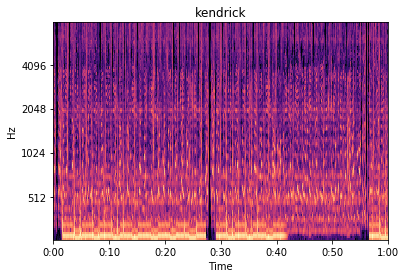

In [55]:
librosa.display.specshow(librosa.power_to_db(S,
                                             ref=np.max),
                         y_axis='mel', fmax=8000,sr=44100,
                         x_axis='time')
plt.title("kendrick")

In [39]:
def load_track(filepath):

    filename = os.path.basename(filepath)
    tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

    COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
               ('track', 'genres'), ('track', 'genres_all')]#, ('track', 'genre_top')]
    for column in COLUMNS:
        tracks[column] = tracks[column].map(ast.literal_eval)

    COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                ('album', 'date_created'), ('album', 'date_released'),
                ('artist', 'date_created'), ('artist', 'active_year_begin'),
                ('artist', 'active_year_end')]
    for column in COLUMNS:
        tracks[column] = pd.to_datetime(tracks[column])

    SUBSETS = ('small', 'medium', 'large')
    tracks['set', 'subset'] = tracks['set', 'subset'].astype('category', categories=SUBSETS, ordered=True)

    COLUMNS = [('track', 'license'), ('artist', 'bio'),('album', 'type'), ('album', 'information')]
    for column in COLUMNS:
        tracks[column] = tracks[column].astype('category')

    return tracks


In [6]:
AUDIO_DIR = "/media/ravi/507412DD7412C59E/fma_small/" #os.environ.get('AUDIO_DIR')

%time tracks = load_track('/home/ravi/metafma/fma_metadata/tracks.csv')
tracks.shape
%time features = utils.load('/home/ravi/metafma/fma_metadata/features.csv')
features.shape

%time echonest = utils.load('/home/ravi/metafma/fma_metadata/echonest.csv')
echonest.shape

/home/ravi/anaconda3/envs/amadeus/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


CPU times: user 7.44 s, sys: 148 ms, total: 7.59 s
Wall time: 7.83 s
CPU times: user 9.7 s, sys: 396 ms, total: 10.1 s
Wall time: 11 s
CPU times: user 520 ms, sys: 12 ms, total: 532 ms
Wall time: 572 ms


(13129, 249)

In [7]:
subset = tracks.index[tracks['set', 'subset'] <= 'small']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((8000, 52), (8000, 518))

In [8]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(MultiLabelBinarizer().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

6400 training examples, 800 validation examples, 800 testing examples
Top genres (22): ['-', 'E', 'F', 'H', 'I', 'P', 'R', 'a', 'c', 'e', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'x']
All genres (114): [1, 2, 6, 10, 12, 15, 16, 17, 18, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 38, 41, 42, 45, 46, 47, 49, 53, 58, 64, 66, 70, 71, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 167, 171, 172, 174, 177, 180, 181, 182, 183, 184, 185, 186, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 314, 337, 359, 360, 361, 362, 400, 401, 404, 439, 440, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 695, 741, 763, 808, 811, 1032, 1060, 1193, 1235]


In [7]:

    k=0

CPU times: user 9.44 s, sys: 488 ms, total: 9.93 s
Wall time: 10.8 s


(106574, 518)

CPU times: user 548 ms, sys: 28 ms, total: 576 ms
Wall time: 622 ms


(13129, 249)

In [9]:
labels = {x:y for x,y in tracks['track','genre_top'].iteritems()}

In [35]:
labels[2099]

'Pop'

In [68]:
i

3880

In [42]:



def make_spec(x,y):
    audio_dir = "/media/ravi/507412DD7412C59E/fma_small/"
    spec_out_dir ="/media/ravi/507412DD7412C59E/spectrogram/"
    aud_path = utils.get_audio_path(audio_dir, x)
    out_path = spec_out_dir + "{}/{}".format(y,x)
    return (song_to_spec(aud_path),out_path)


import time 

st= time.time()
q=0
for x in  train[ (5000<=train) & (train < 5200)]:
    song = make_spec(x,labels[x])
    k=0
    q+=1
    for s in song[0]:
        save_spec(s,song[1]+"_{}".format(k))
        k+=1
    print(time.time()-st,(time.time()-st)/q)

/home/ravi/anaconda3/envs/amadeus/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


73.11139583587646 73.1113965511322
148.7714982032776 74.38574945926666
226.58599042892456 75.52866379419963
305.880158662796 76.47003996372223
387.7396035194397 77.54792084693909
472.0796000957489 78.67993346850078
558.694696187973 79.81352816309247
647.437579870224 80.92969760298729


In [49]:
len(train[ (5200<=train) & (train < 6000)])

8

In [67]:
for i in train[ (3880<train)]:
    break
    aud_path = utils.get_audio_path(audio_dir, i)
    out_path = spec_out_dir + "{}/{}".format(labels[i],i)
    song_to_spec(aud_path,out_path)

/home/ravi/anaconda3/envs/amadeus/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


KeyboardInterrupt: 

In [34]:
print("hi")

hi


In [66]:
k=0
for i in labels:
    if i<3000:
        if labels[i]=="Folk":
            k+=1
print(k,10*k)

40 400
